# Summary

Below I visualize data resulting from pricing items using the Bayesian bandits algorithm within a custom limited simulation of Moonlighter's shop mechanic. 

For more more detailed descriptions and analysis see the corresponding [article](https://cmshymansky.com/StardewSpringProfits/).

Here is code I use to pull data from the SQLite database, process it, visualize it, and style the resulting plots:

In [11]:
from moonlighter_pricing import query_data
import matplotlib.pylab as plt

# Pulling and processing data
def get_simulation_step_inventory_counts():
    return (
        query_data("""
            select 
                rowid,
                * 
            from inventory_changes""")
        .pivot(
            index='rowid',
            columns='item',
            values='change')
        .fillna(0)
        .cumsum()
        [[
            'hardened_steel', 'gold_runes', 'broken_sword', 'golem_core',
            'crystallized_energy', 'glass_lenses', 'iron_bar', 'teeth_stone', 
            'root', 'vine']])
def get_prices_and_bounds():
    return (
        query_data("""
            with price_bounds_and_item_insertion_orders as (
                select 
                    row_number() over(partition by item) as item_insertion_order,
                    * 
                from price_bound_history),
            new_and_old_price_bounds as (
                select
                    a.item_insertion_order,
                    a.reaction_id,
                    a.item,
                    a.low,
                    a.high,
                    b.item_insertion_order as previous_item_insertion_order,
                    b.low as previous_low,
                    b.high as previous_high
                from price_bounds_and_item_insertion_orders a
                left outer join price_bounds_and_item_insertion_orders b on
                    a.item = b.item
                    and a.item_insertion_order - 1 = b.item_insertion_order)
            select
                a.shelf_id,
                a.item,
                b.previous_low,
                b.previous_high,
                a.price,
                a.mood,
                b.low,
                b.high            
            from reactions a
            left outer join new_and_old_price_bounds b on
                a.rowid = b.reaction_id"""))
def get_final_and_best_item_prices(prices_and_bounds):
    return (
        prices_and_bounds    
        .groupby('item')
        .apply(
            lambda x: (
                x            
                .tail(1)
                ['price']
                .values[0]),
            include_groups=False)
        .reset_index()    
        .rename(columns={0: 'final_price'})
        .merge(
            query_data("""
                select
                    item,
                    expensive_upper as best_price
                from price_reaction_bounds"""),
            on='item',
            how='left')
        .set_index('item')
        .sort_values('final_price')
        .rename(
            columns={
                'final_price': 'final', 
                'best_price': 'best'}))
def get_reaction_step_item_prices():
    return (
        query_data(
            """
            select
                *
            from reactions
            """)
        .reset_index()
        .rename(columns={'index': 'reaction_step'})
        [['reaction_step', 'item', 'price']])
def get_best_prices():
    return (
        query_data("""
            select
                item,
                expensive_upper as best_price
            from price_reaction_bounds"""))

# Plotting specific data
def plot_reaction_step_trendline(reaction_step_item_prices, **plot_kwargs):
    (
        reaction_step_item_prices   
        .set_index('reaction_step')
        ['price']
        .plot(
            style='--',
            color='grey', 
            label='', 
            **plot_kwargs))

# Plot styling
def place_legend_right_of_axis(ax, legend_fontsize):
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(
        fontsize=legend_fontsize,
        frameon=False, 
        loc='center left', 
        bbox_to_anchor=(1, 0.5))
def remove_all_but_bottom_axis_spine(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(False)
def remove_left_ticks():
    plt.tick_params(left=False) 
def add_dashed_grid_lines(ax, grid_axis):
    ax.grid(
        axis=grid_axis, 
        linestyle='--')
def change_axis_label_fontsizes(x_axis_label, y_axis_label, fontsize):
    plt.xlabel(
        x_axis_label, 
        fontsize=fontsize)
    plt.ylabel(
        y_axis_label, 
        fontsize=fontsize)
def change_title_fontsize(fontsize, title=''):
    plt.title(
        title, 
        fontsize=fontsize)
def style_plot(ax, fig, fontsize, legend_fontsize, x_axis_label='', 
    y_axis_label='', title='', grid_axis='y'):
    
    remove_all_but_bottom_axis_spine(ax)
    remove_left_ticks()
    add_dashed_grid_lines(ax, grid_axis)
    change_axis_label_fontsizes(x_axis_label, y_axis_label, fontsize)
    place_legend_right_of_axis(ax, legend_fontsize)
    change_title_fontsize(fontsize, title=title)

Here is a graph representing counts of each item in the inventory:

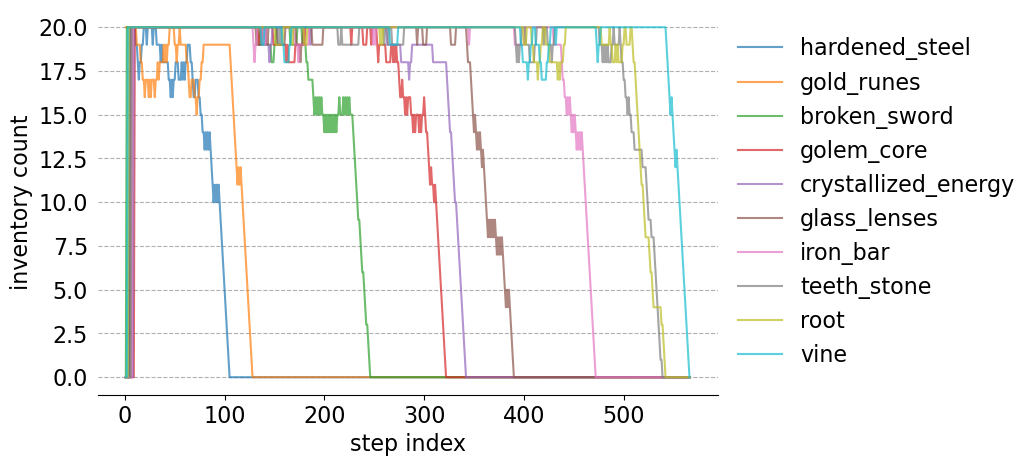

In [29]:
simulation_step_inventory_counts = get_simulation_step_inventory_counts()

fig, ax = plt.subplots(1, 1)
plot_kwargs = {
    'fontsize': 16,
    # 'linewidth': 4,
    'ax': ax,
    'alpha': 0.7,
    'aa': True,
    'figsize': (10, 5)}

simulation_step_inventory_counts.plot(**plot_kwargs)

style_plot(
    ax=ax, 
    fig=fig, 
    fontsize=plot_kwargs['fontsize'], 
    legend_fontsize=plot_kwargs['fontsize'], 
    x_axis_label='step index', 
    y_axis_label='inventory count', 
    grid_axis='y')

Here are the final prices resulting from the algorithm for each item compared to its known ideal price:

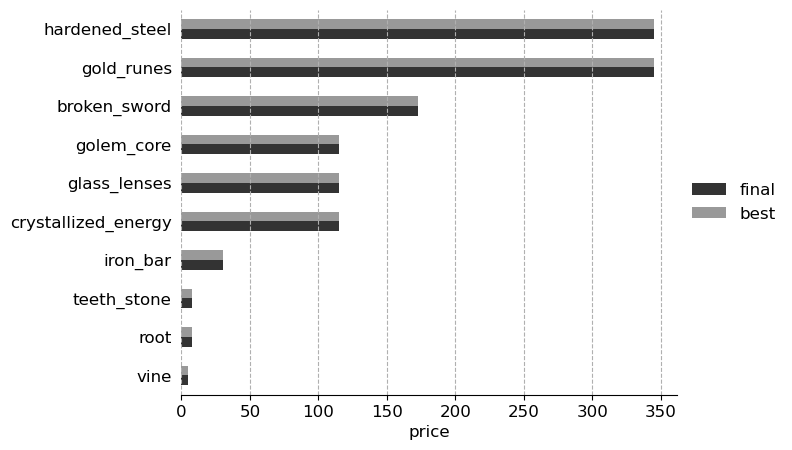

In [30]:
prices_and_bounds = get_prices_and_bounds()
final_and_best_item_prices = get_final_and_best_item_prices(prices_and_bounds)

fig, ax = plt.subplots(1, 1)
plot_kwargs = {
    'fontsize': 12,
    'color': ['black', 'grey'],
    'ax': ax,
    'alpha': 0.8,
    'aa': True,
    'figsize': (8, 5)}

final_and_best_item_prices.plot.barh(**plot_kwargs)

style_plot(
    ax=ax, 
    fig=fig, 
    fontsize=plot_kwargs['fontsize'], 
    legend_fontsize=12, 
    x_axis_label='price', 
    y_axis_label='', 
    grid_axis='x')

Here are prices, in order of customer reaction, with the item (represented by color) that was reacted to:

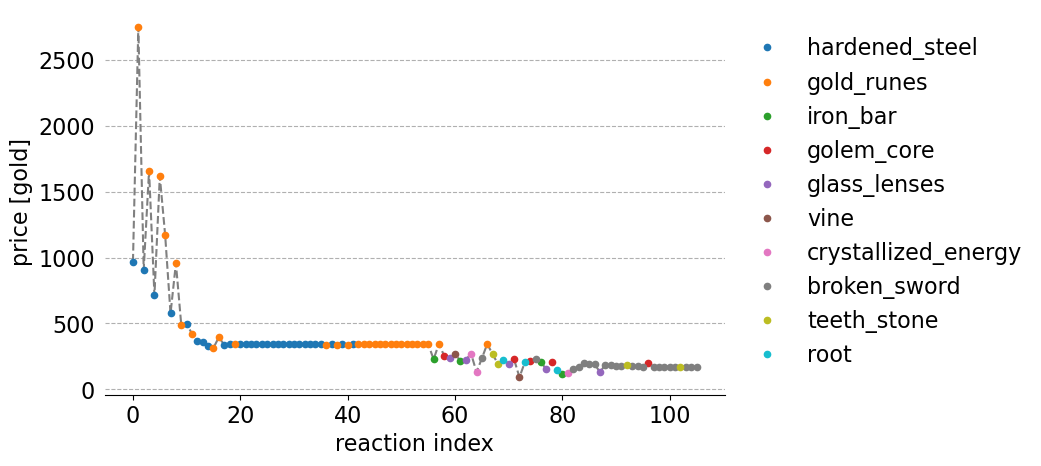

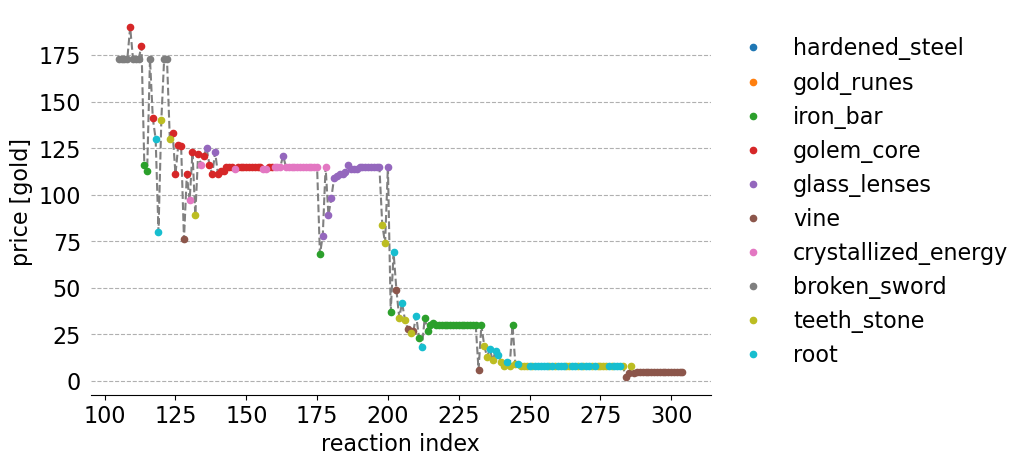

In [31]:
reaction_step_item_prices = get_reaction_step_item_prices()

fig, ax = plt.subplots(1, 1)
plot_kwargs = {
    'fontsize': 16,
    'aa': True,
    'ax': ax,
    'figsize': (10, 5)}

plot_reaction_step_trendline(
    reaction_step_item_prices=(
        reaction_step_item_prices
        .pipe(lambda x: x[x['reaction_step'] <= 105])),
    **plot_kwargs)
for item in reaction_step_item_prices['item'].unique():
    (
        reaction_step_item_prices
        .pipe(lambda x: x[x['reaction_step'] <= 105])
        .pipe(lambda x: x[x['item'] == item])
        .set_index('reaction_step')
        ['price']
        .plot(
            ms=4.5,
            label=item, 
            style='o',
            **plot_kwargs))
style_plot(
    ax=ax, 
    fig=fig, 
    fontsize=plot_kwargs['fontsize'], 
    legend_fontsize=plot_kwargs['fontsize'], 
    x_axis_label='reaction index', 
    y_axis_label='price [gold]', 
    grid_axis='y')

fig, ax = plt.subplots(1, 1)
plot_kwargs = {
    'fontsize': 16,
    'aa': True,
    'ax': ax,
    'figsize': (10, 5)}
(
    reaction_step_item_prices  
    .pipe(lambda x: x[x['reaction_step'] >= 105])
    .set_index('reaction_step')
    ['price']
    .plot(
        label='',
        color='grey',
        style='--',
        **plot_kwargs))
for item in reaction_step_item_prices['item'].unique():
    (
        reaction_step_item_prices
        .pipe(lambda x: x[x['reaction_step'] >= 105])
        .pipe(lambda x: x[x['item'] == item])
        .set_index('reaction_step')
        ['price']
        .plot(
            ms=4.5,
            label=item, 
            style='o',
            **plot_kwargs))
style_plot(
    ax=ax, 
    fig=fig, 
    fontsize=plot_kwargs['fontsize'], 
    legend_fontsize=plot_kwargs['fontsize'], 
    x_axis_label='reaction index', 
    y_axis_label='price [gold]', 
    grid_axis='y')

I split this into 2 plots for clarity.

Here is a plot of the Thompson sampling competitions between items, where prices are randomly drawn from each item's ideal price bounds:

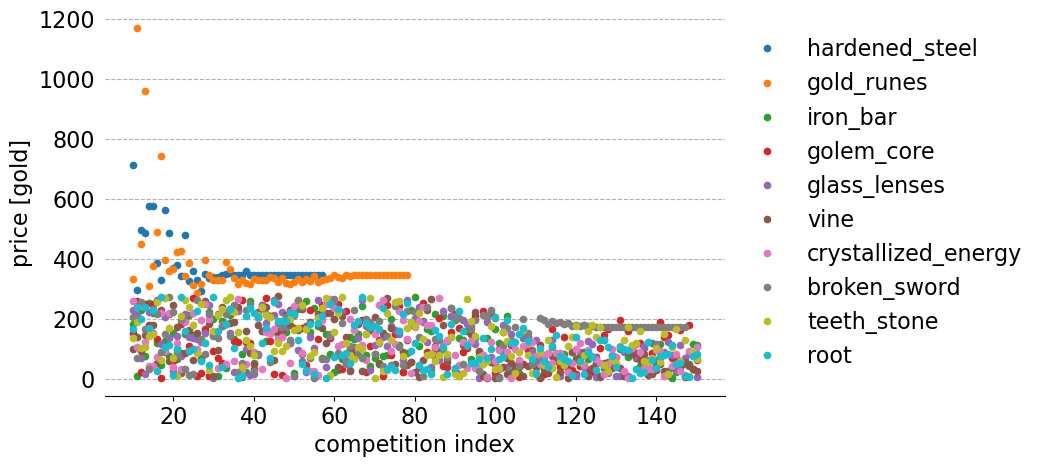

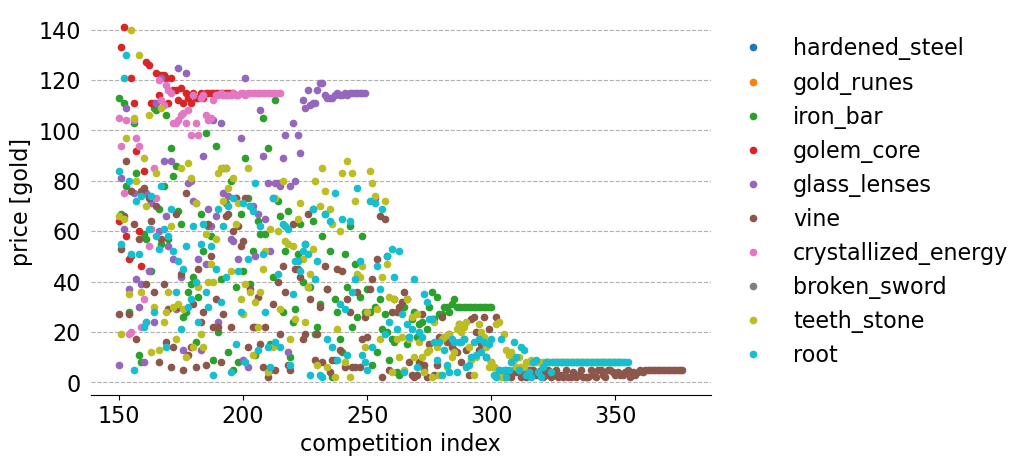

In [32]:
thompson_competitions = (
    query_data("""
        select
            *
        from thompson_competitions
    """))
item_colors = {
    'hardened_steel': '#1f77b4',
    'gold_runes': '#ff7f0e',
    'iron_bar': '#2ca02c',
    'golem_core': '#d62728',
    'glass_lenses': '#9467bd',
    'vine': '#8c564b',
    'crystallized_energy': '#e377c2',
    'broken_sword': '#7f7f7f',
    'teeth_stone': '#bcbd22',
    'root': '#17becf'}
fig, ax = plt.subplots(1, 1)    
for item in item_colors.keys():
    item_data = (
        thompson_competitions
        .pipe(lambda x: x[x['competition_ind'].between(10, 150)])
        .pipe(lambda x: x[x['item'] == item])
        .set_index('competition_ind'))
    plot_kwargs = {
        'fontsize': 16,        
        'aa': True,
        'figsize': (10, 5),
        # 'alpha': 0.5,
        'color': item_colors[item],
        'ax': ax}
    type_specific_plot_kwargs = {
        'sampled_price': {
            'ms': 4.5,
            'style': 'o',
            'label': item},
        'low': {
            'linestyle': '-',
            'label': ''},
        'high': {
            'linestyle': '-',
            'label': ''}}
    for plot_type in ['sampled_price']:
        (
            item_data
            [plot_type]
            .plot(
                **plot_kwargs,
                **type_specific_plot_kwargs[plot_type]))
style_plot(
    ax=ax, 
    fig=fig, 
    fontsize=plot_kwargs['fontsize'], 
    legend_fontsize=plot_kwargs['fontsize'], 
    x_axis_label='competition index', 
    y_axis_label='price [gold]', 
    # title=item,
    grid_axis='y')

fig, ax = plt.subplots(1, 1)    
for item in item_colors.keys():
    item_data = (
        thompson_competitions
        .pipe(lambda x: x[x['competition_ind'] >= 150])
        .pipe(lambda x: x[x['item'] == item])
        .set_index('competition_ind'))
    plot_kwargs = {
        'fontsize': 16,        
        'aa': True,
        'figsize': (10, 5),
        # 'alpha': 0.5,
        'color': item_colors[item],
        'ax': ax}
    type_specific_plot_kwargs = {
        'sampled_price': {
            'ms': 4.5,
            'style': 'o',
            'label': item},
        'low': {
            'linestyle': '-',
            'label': ''},
        'high': {
            'linestyle': '-',
            'label': ''}}
    for plot_type in ['sampled_price']:
        (
            item_data
            [plot_type]
            .plot(
                **plot_kwargs,
                **type_specific_plot_kwargs[plot_type]))
style_plot(
    ax=ax, 
    fig=fig, 
    fontsize=plot_kwargs['fontsize'], 
    legend_fontsize=plot_kwargs['fontsize'], 
    x_axis_label='competition index', 
    y_axis_label='price [gold]', 
    # title=item,
    grid_axis='y')

Again I split the plot into 2 for clarity.

Here I zoom in on the plot around steps 290 to 380 and include the upper/lower ideal price bounds, from which prices are sampled from:

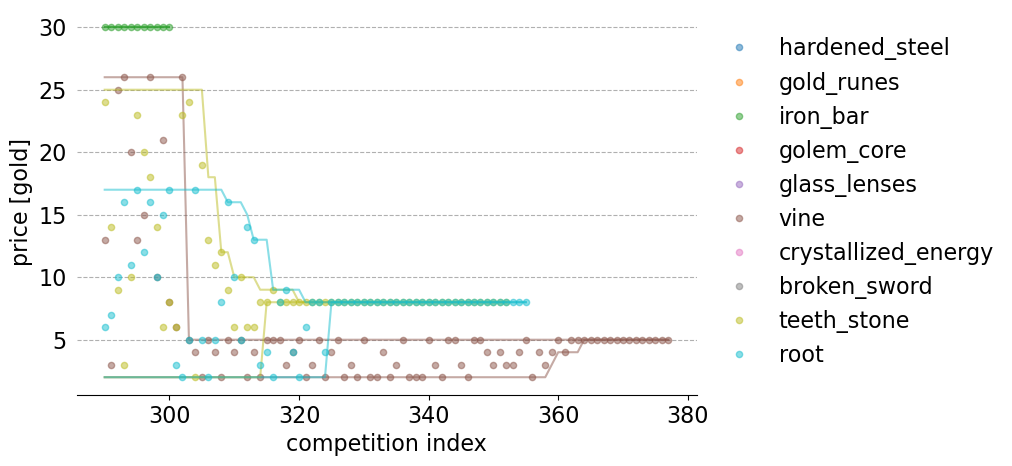

In [47]:
fig, ax = plt.subplots(1, 1)    
for item in item_colors.keys():
    item_data = (
        thompson_competitions
        .pipe(lambda x: x[x['competition_ind'].between(290, 400)])
        .pipe(lambda x: x[x['item'] == item])
        .set_index('competition_ind'))
    plot_kwargs = {
        'fontsize': 16,        
        'aa': True,
        'figsize': (10, 5),
        'alpha': 0.5,
        'color': item_colors[item],
        'ax': ax}
    type_specific_plot_kwargs = {
        'sampled_price': {
            'ms': 4.5,
            'style': 'o',
            'label': item},
        'price_lower_bound': {
            'linestyle': '-',
            'label': ''},
        'price_upper_bound': {
            'linestyle': '-',
            'label': ''}}
    for plot_type in ['sampled_price', 'price_lower_bound', 'price_upper_bound']:
        (
            item_data
            [plot_type]
            .plot(
                **plot_kwargs,
                **type_specific_plot_kwargs[plot_type]))
style_plot(
    ax=ax, 
    fig=fig, 
    fontsize=plot_kwargs['fontsize'], 
    legend_fontsize=plot_kwargs['fontsize'], 
    x_axis_label='competition index', 
    y_axis_label='price [gold]', 
    # title='Item price Thompson competitions',
    grid_axis='y')

Here are plots, for each item, representing the progression of customer reactions and the algorithm's understanding of what the highest acceptable price might as the simulation progresses:

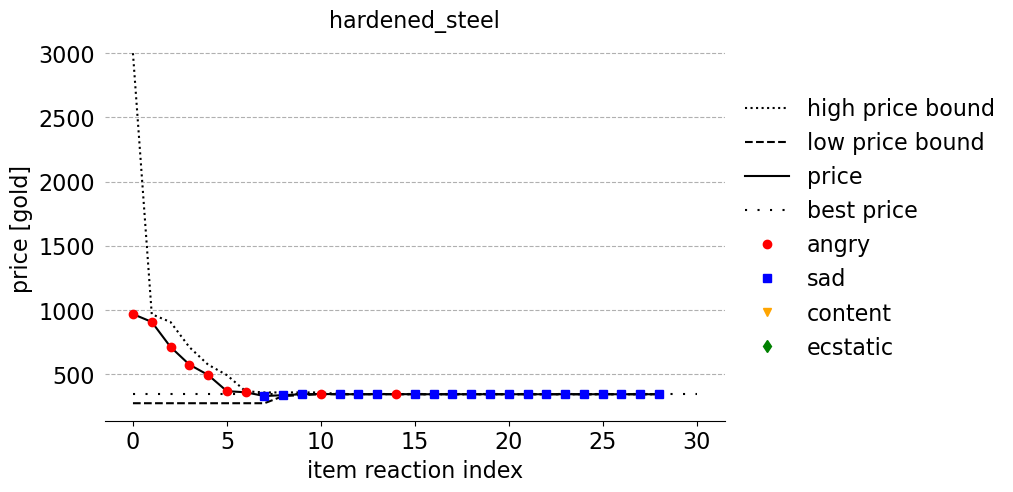

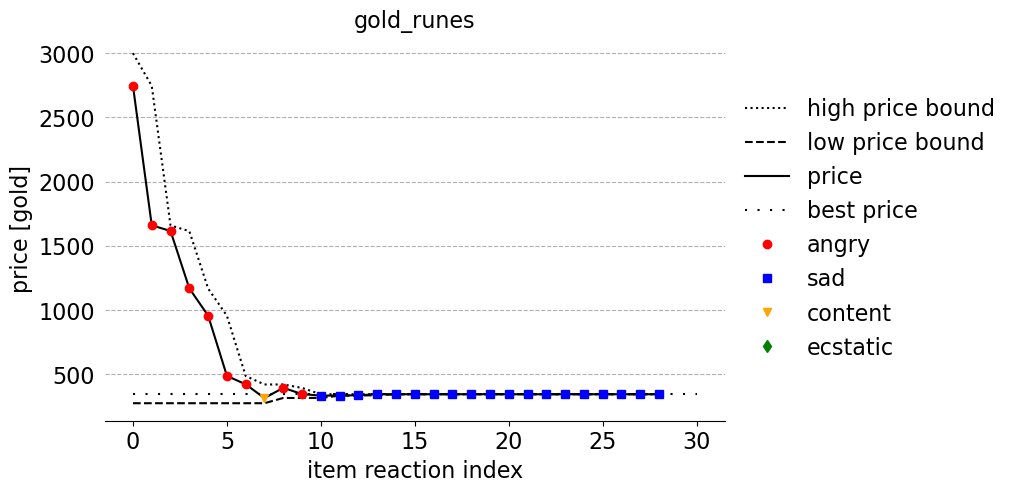

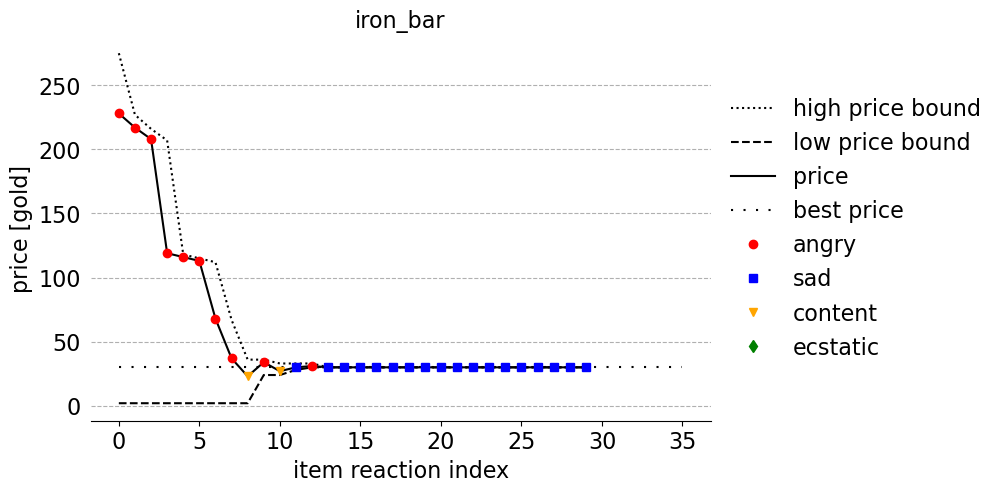

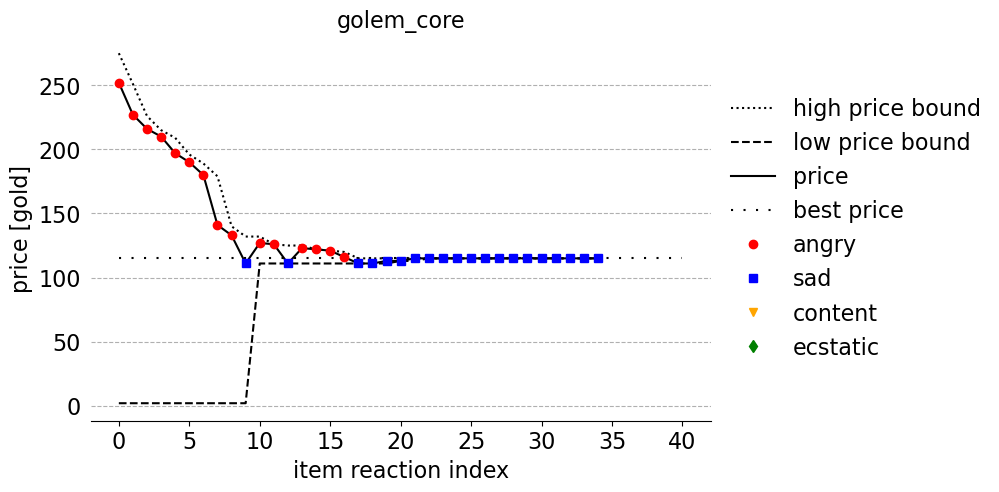

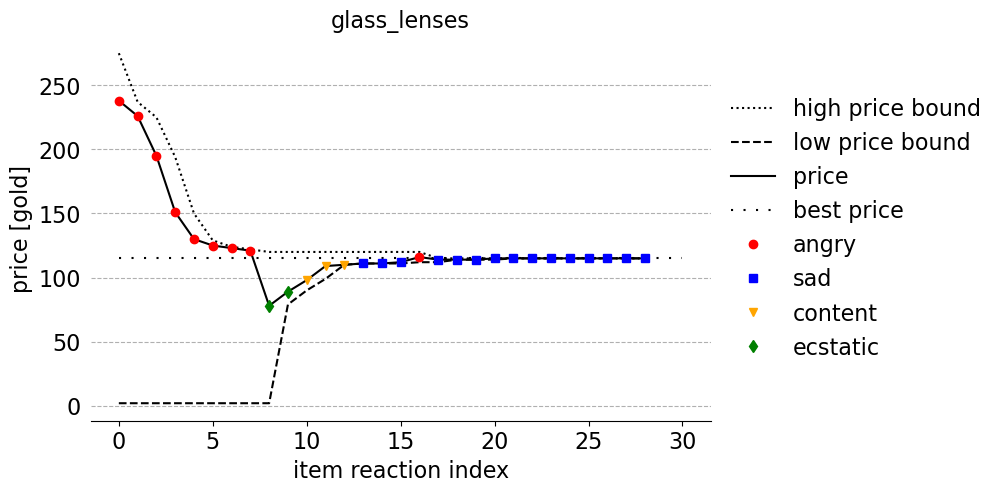

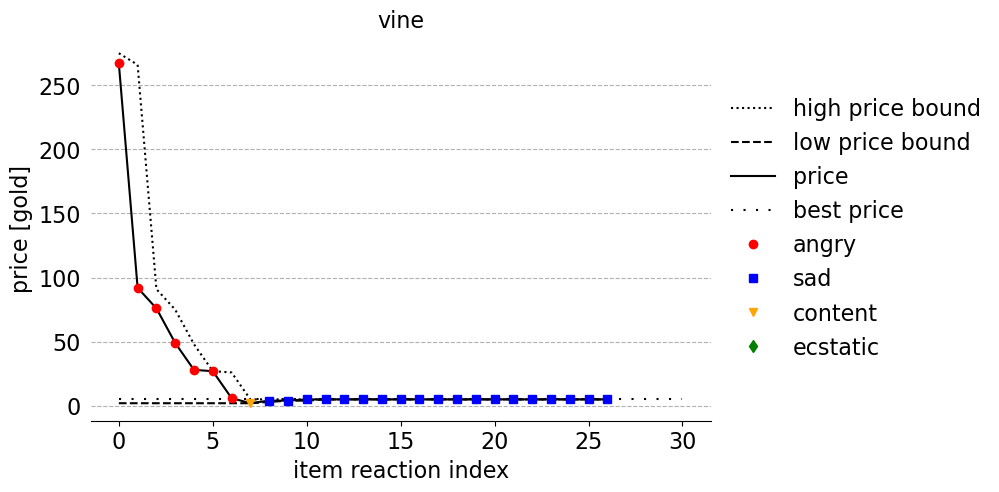

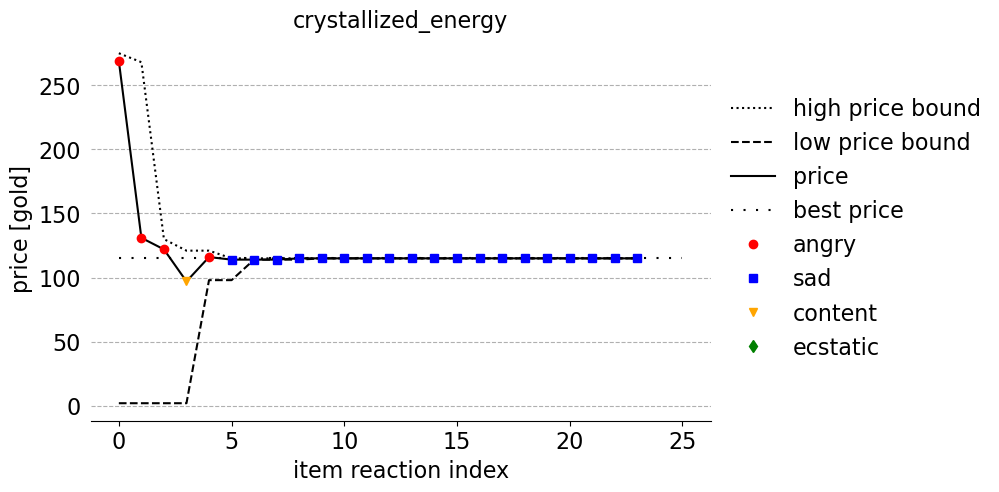

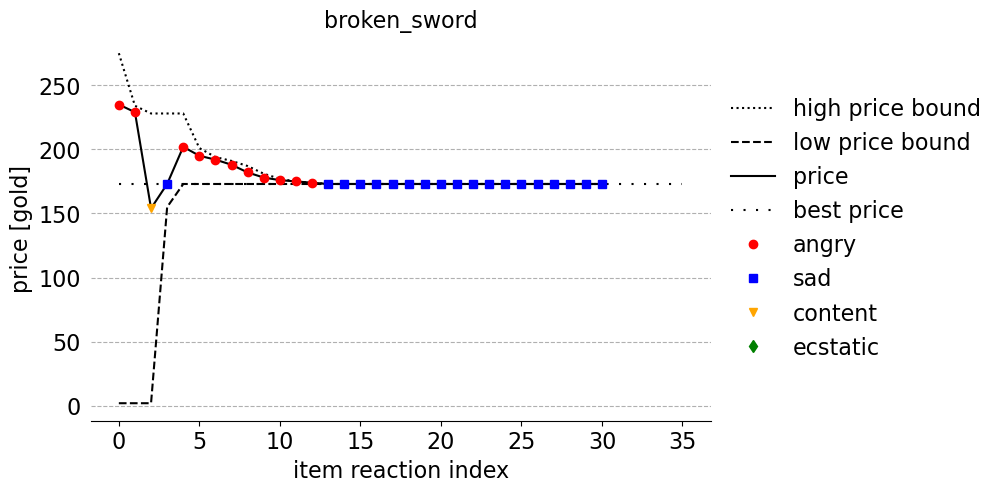

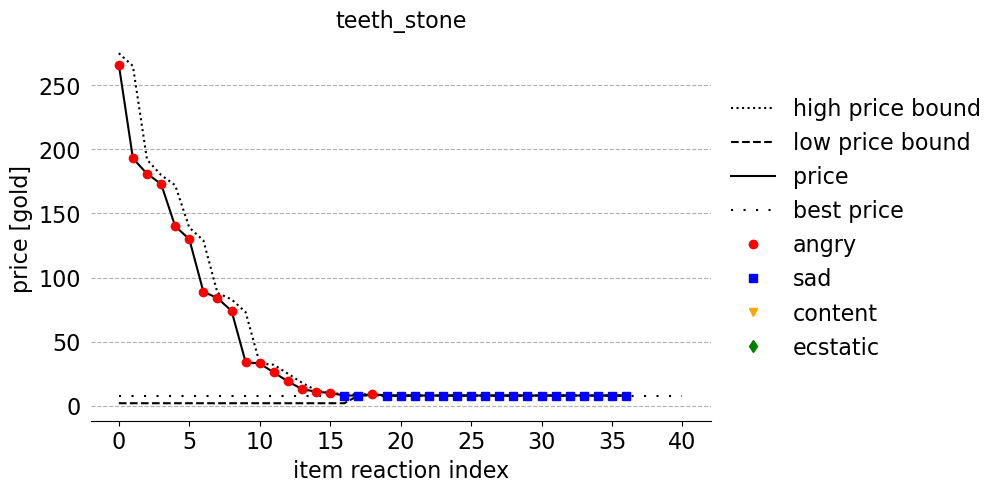

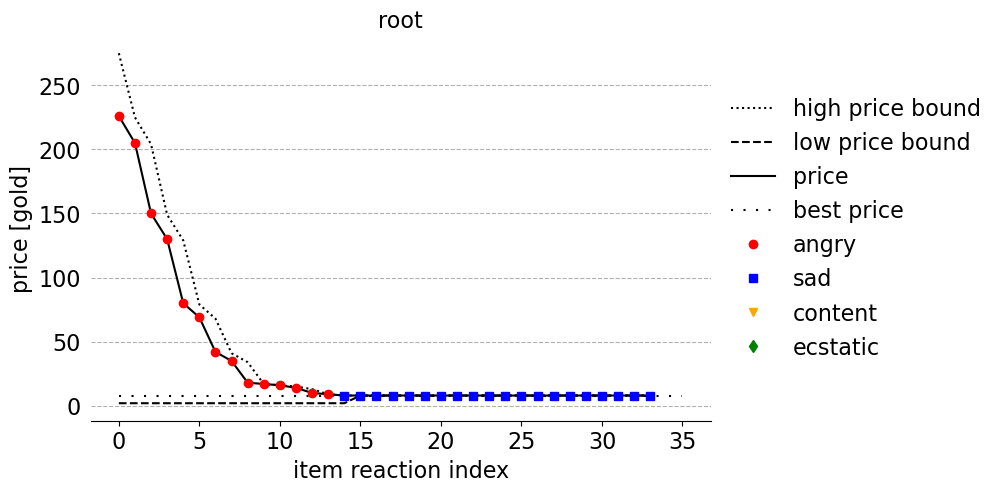

In [34]:
mood_plot_kwargs = {
    'angry': {
        'label': 'angry',
        'color': 'red',
        'style': 'o'},
    'sad': {
        'label': 'sad',
        'color': 'blue',
        'style': 's'},
    'content': {
        'label': 'content',
        'color': 'orange',
        'style': 'v'},
    'ecstatic': {
        'label': 'ecstatic',
        'color': 'green',
        'style': 'd'}}

best_prices = get_best_prices()
for item in prices_and_bounds['item'].unique():
    fig, ax = plt.subplots(1, 1)
    plot_kwargs = {
        'title': item.replace('_', ' '),
        'fontsize': 16,
        'ax': ax,
        'aa': True,
        'figsize': (10, 5)}
    item_price_and_bounds = (
        prices_and_bounds
        .pipe(lambda x: x[x['item'] == item])
        .reset_index())
    best_item_price = (
        int(
            best_prices
            .pipe(lambda x: x[x['item'] == item])
            ['best_price']
            .values
            [0]))
    
    (
        item_price_and_bounds
        ['previous_high']
        .plot(
            label='high price bound',
            color='black',
            style=':',
            **plot_kwargs))
    (
        item_price_and_bounds
        ['previous_low']    
        .plot(
            label='low price bound',
            style='--',
            color='black',
            **plot_kwargs))  
    (
        item_price_and_bounds
        ['price']    
        .plot(
            style='-',
            color='black',
            label='price',
            **plot_kwargs))
    (
        ax.hlines(
            best_item_price, 
            0,
            ax.get_xticks().max(), 
            linestyle=(0, (1, 5)),
            color='black',
            label='best price'))
    for mood, mood_specific_kwargs in mood_plot_kwargs.items():
        (
            item_price_and_bounds
            .pipe(lambda x: x[x['mood'] == mood])
            ['price']
            .plot(
                **mood_specific_kwargs,
                **plot_kwargs))    
    
    style_plot(
        ax=ax, 
        fig=fig, 
        fontsize=plot_kwargs['fontsize'], 
        legend_fontsize=plot_kwargs['fontsize'], 
        x_axis_label='item reaction index', 
        y_axis_label='price [gold]', 
        title=item,
        grid_axis='y')    

Each plot consists of the algorithm's price for that item (y-axis value) vs the order (x-axis) of any customer reaction (mood indicated by marker color), the lower bound that the algorithm understands of the ideal price prior to the reaction (dashed), the same for the upper bound (closer-spaced dots), and the ideal price (horizontal line of wider-spaced dots)